In [3]:
"""
demo
Author: vsulli
Date: 26 April 2025

- Select language (Spanish or German)
- Convert the .srt file to a dataframe
- Clean the dataframe
- Export the dataframe to a .csv file
"""

'\ndemo\nAuthor: vsulli\nDate: 26 April 2025\n\n- Select language (Spanish or German)\n- Convert the .srt file to a dataframe\n- Clean the dataframe\n- Export the dataframe to a .csv file\n'

In [9]:
# Standard library imports
import csv
import json
import re
import string

# Other library imports
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pysrt
import seaborn as sns
import spacy
import tkinter as tk

from langdetect import detect, LangDetectException
from nltk.corpus import stopwords
from PyMultiDictionary import MultiDictionary, DICT_EDUCALINGO
from textblob import TextBlob
from tkinter import filedialog
from tqdm.notebook import tqdm


# Allows for displaying multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# PyMultiDictionary allows you to get meanings, translations, synonyms, and antonyms for supported langs
'''[bengali' (bn),'chinese (zh)', english' (en), 'french' (fr), 'german' (de), 
'italian' (it),'portuguese' (pt), 'romanian' (ro), 'russian'(ru), 'spanish'(es), 
'turkish' (tr)]'''
dictionary = MultiDictionary()


"[bengali' (bn),'chinese (zh)', english' (en), 'french' (fr), 'german' (de), \n'italian' (it),'portuguese' (pt), 'romanian' (ro), 'russian'(ru), 'spanish'(es), \n'turkish' (tr)]"

In [10]:
# Basic German configuration
lang = ['german', 'de'] # ['spanish', 'es']
tags = [lang, 'sentence::mining', 'Tatort', 'sentence::recognition'] # input the desired tags for ANKI
fields = [lang, 'defs', tags] 
srt_file = "de_demo.srt" # first 20 subtitle lines
# Load spaCy language model
nlp_de = spacy.load(r"C:\Users\paro\Documents\GitHub\SRT2CSV\de_core_news_sm-3.0.0\de_core_news_sm-3.0.0\de_core_news_sm\de_core_news_sm-3.0.0")

In [6]:
# Basic Spanish configuration
lang = ['spanish', 'es']
tags = [lang, 'sentence::mining', 'La Caza', 'sentence::recognition'] 
fields = [lang, 'defs', tags] 
srt_file = "es_demo.srt" # first 20 subtitle lines
nlp_es = spacy.load(r"C:\Users\paro\Documents\GitHub\SRT2CSV\es_core_news_sm-3.8.0\es_core_news_sm-3.8.0\es_core_news_sm\es_core_news_sm-3.8.0")

C:\Users\paro\Coding Projects\Cato-AI_vs1.2\cuda\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [11]:
# Load stopwords for the language selected
# ex) "spanish"
lang_sw = stopwords.words(lang[0])

In [12]:
# Specify the encoding if UnicodeDecodeError
# You can open the file in NotePad and check SaveAs for default encoding
# ANSI, UTF-8
subs = pysrt.open(srt_file, encoding='utf-8')

In [13]:
def remove_formatting(subfile):
    """
    Removes subtitle timing information and tags by reading through each line using regex.
    
    Args:
        subfile (SubRipFile): A list like object that has indices, start/end times, and the text.
        
    Returns:
        subfile (SubRipFile): A cleaned SubRipFile
    """
    
    for i in range(len(subfile)):
        # Strip white space from beginning
        # Replace all characters between < and > with ""
        # Using regex
        subfile[i].text = subfile[i].text.lstrip()
        subfile[i].text = re.sub(r'<c.vtt_\w+>\s*"*', "", subfile[i].text)
        subfile[i].text = re.sub("</c>", "", subfile[i].text)
        # Replace "-" with ""
        subfile[i].text = re.sub("-", "", subfile[i].text)

    return subfile

In [14]:
subs = remove_formatting(subs)

In [15]:
# Create a dataframe with desired column name from a SubRipFile
def create_dataframe(subfile, col_name):
    df = pd.DataFrame(columns=[col_name])
    for i in range(len(subfile)):
        df.loc[i] = subfile[i].text
    return df

In [16]:
df = create_dataframe(subs, 'Subtitle')
df

,Subtitle
0,<font color=#ffffff>.</font>
1,<font color=#ffffff>(Motor wird angelassen)</f...
2,<font color=#ffffff>Herr Landsberger?</font>\n...
3,<font color=#ffffff>Motorhaube und Kofferraum ...
4,<font color=#ffffff>Machen Sie den Koffer auf!...
5,"<font color=#ffffff>Die Sitzbank, bitte!</font>"
6,<font color=#ffffff>Das Kind schläft.</font>
7,<font color=#ffffff>Und außerdem geht es ihm n...
8,<font color=#ffffff>Handschuhfach!</font>
9,<font color=#ffffff>Danke.</font>\n<font color...


In [17]:
def remove_font_tags(df, col):
    """
    Remove subtitle font tags from a dataframe column by extracting text between '>' and '<'.
    If no match is found, the original text is used.
    
    Args:
        df (pd.DataFrame): The source DataFrame to process.
        col (str): The column in that DataFrame to process
    
    Returns:
        list: A list of all the cleaned rows.
    """
    
    new_df_list = []
    for row in range(len(df[col])):
        # Select everything between two characters > and < 
        match = re.findall(r'>(.*?)<', df[col][row])
        if match:
            # Add just that text to new df
            new_df_list.append(match[0])
        else:
            # Add original row to new df
            new_df_list.append(df[col][row])
    return new_df_list

In [18]:
new_df_list = remove_font_tags(df,'Subtitle')

# create new df without font tags
new_df = pd.DataFrame(new_df_list)
new_df.rename(columns={0:"Subtitle"}, inplace=True)
new_df

,Subtitle
0,.
1,(Motor wird angelassen)
2,Herr Landsberger?
3,"Motorhaube und Kofferraum öffnen,"
4,Machen Sie den Koffer auf!
5,"Die Sitzbank, bitte!"
6,Das Kind schläft.
7,Und außerdem geht es ihm nicht gut.
8,Handschuhfach!
9,Danke.


In [19]:
# Combine multi-line texts
def combine_rows(df, col):
    """
     Go through a DataFrame row by row and combine them until a character 
        that represents the end of a line appears.
        
        Args:
            df (pd.DataFrame): The source DataFrame to process.
            col (str): The column in that DataFrame to process

        Returns:
            new_df(pd.DataFrame): A DataFrame that multi-line text combined 
    """
    new_df_list = []
    current_row = ""
    for row in df[col]:
        # end characters at index -1 must be ) . ? ! 
        if row[-1] == ")" or row[-1] == "." or row[-1] == "?" or row[-1] == "!":
            current_row += row
            # Append these rows to list and then create new df - more efficient than appending to df
            new_df_list.append(current_row)
            current_row = ""
        else:
            current_row += row

    # create new df from the list of combined rows
    new_df = pd.DataFrame(new_df_list)
    new_df.rename(columns={0:col}, inplace=True)
    return new_df

In [20]:
# Basic exploratory data analysis
def explore_data(dataframe, column):
    print(dataframe.head())
    print(dataframe.shape)
    print(dataframe.dtypes)
    print(dataframe.describe(include='all'))
    
explore_data(new_df, 'Subtitle')

                            Subtitle
0                                  .
1            (Motor wird angelassen)
2                  Herr Landsberger?
3  Motorhaube und Kofferraum öffnen,
4         Machen Sie den Koffer auf!
(20, 1)
Subtitle    object
dtype: object
       Subtitle
count        20
unique       20
top           .
freq          1


In [21]:
# Convert to lowercase
def make_lowercase(df, source_col, target_col):
    df[target_col] = df[source_col].str.lower()
    return df

In [22]:
# Remove punctuation
def remove_punctuation(df, source_col, target_col):
    # ^ is a negation inside brackets (anything except)
    # Starts with any word, digits, or underscore, white space character, apostrophe, + means any character in the string
    df[target_col] = df[source_col].str.replace(r"[^\w\s']+", ' ', regex = True)
    return df

In [23]:
# Remove newline \n character
def remove_newline(df, source_col, target_col):
    df[target_col] = df[source_col].str.replace(r'\n', ' ', regex = True) # replaces the \n with a space
    return df

In [25]:
# Removing newline from df
clean_df = remove_newline(new_df, 'Subtitle', 'Subtitle')
print(clean_df.head())

clean_df[19:20]

                            Subtitle
0                                  .
1            (Motor wird angelassen)
2                  Herr Landsberger?
3  Motorhaube und Kofferraum öffnen,
4         Machen Sie den Koffer auf!


,Subtitle
19,Was geht uns das an?


In [26]:
# Making 'Lowercase' column in df
clean_df = make_lowercase(clean_df, 'Subtitle', 'Lowercase')
print(clean_df.head())

                            Subtitle                          Lowercase
0                                  .                                  .
1            (Motor wird angelassen)            (motor wird angelassen)
2                  Herr Landsberger?                  herr landsberger?
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen,
4         Machen Sie den Koffer auf!         machen sie den koffer auf!


In [27]:
# Making 'No Punctuation' column in df
clean_df = remove_punctuation(clean_df, 'Subtitle', 'No Punctuation')
print(clean_df.head())
clean_df[19:20]

                            Subtitle                          Lowercase  \
0                                  .                                  .   
1            (Motor wird angelassen)            (motor wird angelassen)   
2                  Herr Landsberger?                  herr landsberger?   
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen,   
4         Machen Sie den Koffer auf!         machen sie den koffer auf!   

                      No Punctuation  
0                                     
1             Motor wird angelassen   
2                  Herr Landsberger   
3  Motorhaube und Kofferraum öffnen   
4         Machen Sie den Koffer auf   


,Subtitle,Lowercase,No Punctuation
19,Was geht uns das an?,was geht uns das an?,Was geht uns das an


In [28]:
# The basic tokenizer splits on apostrophe
# Tweet tokenizer does not

def tokenize_words(df, source_col):
    df['Word Tokens'] = df[source_col].apply(nltk.word_tokenize)
    return df

In [29]:
# Breaking down 'No Punctuation' column into individual words
clean_df = tokenize_words(clean_df, 'No Punctuation')
clean_df['Word Tokens']

0                                             []
1                      [Motor, wird, angelassen]
2                            [Herr, Landsberger]
3          [Motorhaube, und, Kofferraum, öffnen]
4                [Machen, Sie, den, Koffer, auf]
5                         [Die, Sitzbank, bitte]
6                           [Das, Kind, schläft]
7     [Und, außerdem, geht, es, ihm, nicht, gut]
8                                [Handschuhfach]
9                                        [Danke]
10                               [nicht, hörbar]
11                             [Hörst, du, noch]
12           [Ärmliche, Nee, förmliche, Anfrage]
13            [an, die, Strafverfolgungsbehörde]
14         [Auf, einem, Rastplatz, bei, Leipzig]
15                     [fand, man, einen, toten]
16                         [Keine, Verletzungen]
17                       [Hier, lies, doch, mal]
18                [trug, das, Kind, DDRKleidung]
19                     [Was, geht, uns, das, an]
Name: Word Tokens, d

In [30]:
def tokenize_sentences(df, source_col):
    df['Sentence Tokens'] = df[source_col].apply(nltk.sent_tokenize)
    return df

In [31]:
# Breaking down 'No Punctuation' column into sentence tokens
clean_df['Sentence Tokens'] = clean_df['No Punctuation'].apply(nltk.sent_tokenize)
clean_df['Sentence Tokens']

0                                       []
1                 [ Motor wird angelassen]
2                       [Herr Landsberger]
3       [Motorhaube und Kofferraum öffnen]
4              [Machen Sie den Koffer auf]
5                    [Die Sitzbank  bitte]
6                       [Das Kind schläft]
7     [Und außerdem geht es ihm nicht gut]
8                          [Handschuhfach]
9                                  [Danke]
10                         [ nicht hörbar]
11                         [Hörst du noch]
12    [ Ärmliche   Nee  förmliche Anfrage]
13        [an die Strafverfolgungsbehörde]
14      [ Auf einem Rastplatz bei Leipzig]
15                  [fand man einen toten]
16                    [Keine Verletzungen]
17                   [Hier  lies doch mal]
18         [    trug das Kind DDRKleidung]
19                   [Was geht uns das an]
Name: Sentence Tokens, dtype: object

In [32]:
# Remove stopwords

# Open existing file of removed words
def load_removed_words(lang):
    try:
        with open(lang[1]+"_removed_words.json", "r") as f:
            removed_words = set(json.load(f))
    #JSONDecodeError - if file is empty       
    except (FileNotFoundError, json.JSONDecodeError):
        removed_words = set()
    
    removed_words.update(lang_sw)

    # save new set
    with open(lang[1]+"_removed_words.json", "w") as f:
        json.dump(list(removed_words), f)
        
    # return set of removed words
    return removed_words

In [33]:
# Extend the stop words with list of custom words
# uppr_flag - all uppercase version of word removed
# lwr_flag - all lowercase version of word removed
# title_flag - title case of word removed
def extend_removed_words(lang, custom_stop_words, uppr_flag=False, lwr_flag=False, title_flag=False):
    # save to JSON file
    try:
        with open(lang[1]+"_removed_words.json", "r") as f:
            removed_words = set(json.load(f))
    except FileNotFoundError:
        removed_words = set()
    
    if uppr_flag:
        removed_words.update(list(map(str.upper, custom_stop_words)))
    
    if lwr_flag:
        removed_words.update(list(map(str.lower, custom_stop_words)))
        
    if title_flag:
        removed_words.update(list(map(str.title, custom_stop_words)))
    
    # Remove only original list provided
    removed_words.update(custom_stop_words)

    with open(lang[1]+"_removed_words.json", "w") as f:
        json.dump(list(removed_words), f)
        
    return removed_words

In [34]:
# Add back previously removed words
def add_back_words(lang, desired_words, uppr_flag=False, lwr_flag=False, title_flag=False):
    try:
        with open(lang[1]+"_removed_words.json", "r") as f:
            removed_words = set(json.load(f))

    except (FileNotFoundError, json.JSONDecodeError):
        removed_words = set()
        
    if uppr_flag:
         removed_words.difference_update(list(map(str.upper, desired_words)))
    
    if lwr_flag:
         removed_words.difference_update(list(map(str.lower, desired_words)))
        
    if title_flag:
        removed_words.difference_update(list(map(str.title, desired_words)))

    # Add back words (remove from set)
    removed_words.difference_update(desired_words)

    with open(lang[1]+"_removed_words.json", "w") as f:
        json.dump(list(removed_words), f)
        
    return removed_words

In [35]:
removed_words = load_removed_words(lang)

# Eliminating names of characters, places, pronouns, etc.
custom_stop_words = [] # Ex) ["Ana", "Lucía"]

removed_words = extend_removed_words(lang, custom_stop_words, title_flag=True)

# Adding back previously removed words
desired_words = [] # Ex) ["Ana"]

removed_words = add_back_words(lang, desired_words, title_flag=True)

In [36]:
# Creating new column without removed words
clean_df['No Stop Words'] = clean_df['Word Tokens'].apply(lambda x: [item for item in x if item not in removed_words])
clean_df[19:20]

,Subtitle,Lowercase,No Punctuation,Word Tokens,Sentence Tokens,No Stop Words
19,Was geht uns das an?,was geht uns das an?,Was geht uns das an,"[Was, geht, uns, das, an]",[Was geht uns das an],[]


In [37]:
clean_df[9:10]['Subtitle']
clean_df[0:20]['No Stop Words']

9    Danke.
Name: Subtitle, dtype: object

0                                      []
1                     [Motor, angelassen]
2                                      []
3        [Motorhaube, Kofferraum, öffnen]
4                                [Koffer]
5                              [Sitzbank]
6                               [schläft]
7                              [außerdem]
8                         [Handschuhfach]
9                                      []
10                               [hörbar]
11                                [Hörst]
12    [Ärmliche, Nee, förmliche, Anfrage]
13              [Strafverfolgungsbehörde]
14                            [Rastplatz]
15                          [fand, toten]
16                         [Verletzungen]
17                                 [lies]
18                    [trug, DDRKleidung]
19                                     []
Name: No Stop Words, dtype: object

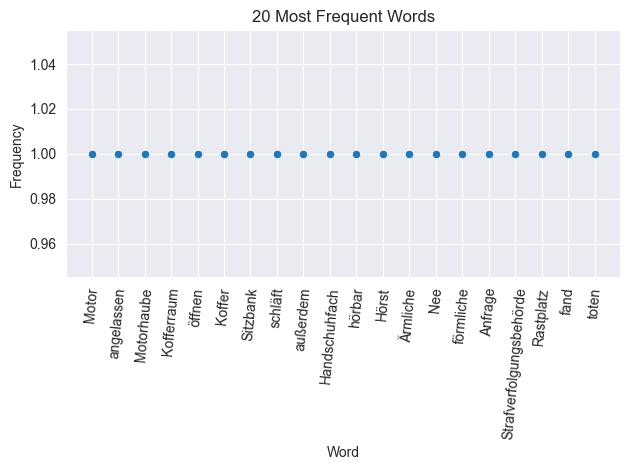

In [38]:
# Create a frequency diagram for 'freq' most frequent words
def create_freq_diagram(df, col, freq):
    # List of all words
    words = []
    for index, row in df.iterrows():
        for word in row[col]:
            words.append(word)

    freq_words = nltk.FreqDist(words)
    
    freq_df = pd.DataFrame(freq_words.items(), columns=['Word', 'Frequency']).nlargest(freq, 'Frequency')
    
    # Plot the word frequencies
    sns.set_style('darkgrid')
    sns.scatterplot(x='Word', y='Frequency', data=freq_df)
    plt.title(f"{freq} Most Frequent Words")
    plt.xticks(rotation=85)
    plt.tight_layout()
    plt.show()

create_freq_diagram(clean_df, 'No Stop Words', 20) 

In [39]:
# Find the rows that contain a specific word
def find_word(df, word):
    pattern = rf'\b{re.escape(word)}\b'

    # Rows where the subtitle column contains the word
    row_matches = clean_df[clean_df['Subtitle'].str.contains(pattern, case=False, regex=True, na=False)]

    # Return just the Subtitle column
    sub_col_match = row_matches[['Subtitle']]
    return sub_col_match

In [40]:
# Finding the original subtitle lines that include the word
matches = find_word(clean_df, 'Motor')
matches

,Subtitle
1,(Motor wird angelassen)


In [41]:
# Spanish example definition
# PyMultiDictionary to get definition
# retrieves part of speech, explanations
print(dictionary.meaning('es', 'ladrar', dictionary=DICT_EDUCALINGO))

(['Verb'], 'The first definition of barking in the dictionary of the real academy of the Spanish language is said of a dog: Give barks. Another meaning of barking in the dictionary is to threaten without rushing. To bark is also to challenge, to label, ordinarily with malignity. La primera definición de ladrar en el diccionario de la real academia de la lengua española es dicho de un perro: Dar ladridos. Otro significado de ladrar en el diccionario es amenazar sin acometer. Ladrar es también impugnar, motejar, de ordinario con malignidad.', '')


In [42]:
# German example definition
print(dictionary.meaning('de', 'bellen', dictionary=DICT_EDUCALINGO))

(['Verb'], 'repeated short, powerful sounds of themselves give barking sounds speak in hoarse, loud tone, call o. Ä. cause a hard, barking noise. repeatedly making short, strong sounds. Example The dog barked loudly. wiederholt kurze, kräftige Laute von sich geben bellende Laute von sich geben in heiserem, lautem ton sprechen, rufen o.\u2000Ä. ein hartes, bellendes Geräusch hervorbringen, verursachen. wiederholt kurze, kräftige Laute von sich gebenBeispielder Hund bellte laut.', '')


In [43]:
# Extract only desired language from definition
def extract_desired_lang(word, lang):
    # Get the dictionary result
    res = dictionary.meaning(lang, word, dictionary=DICT_EDUCALINGO)
    
    if not res or not res[1]:
        return None
    
    pos_tags, text, _ = res
    
    # Split into sentences
    sentences = text.split('. ')
    
    # Desired language sentences
    my_sentences = []
    
    for sent in sentences:
        sent = sent.strip() 
        if not sent:
            continue
        
        try:
            detected_lang = detect(sent)
            
            # Check if desired lang
            if detected_lang == lang:
                my_sentences.append(sent)
        except LangDetectException:
            # Skip if not desired lang
            continue
    
    # Combine sentences and return
    return ' '.join(my_sentences)

In [44]:
# Updated to get the article for German and Spanish
def get_article_for_noun(lang, noun):
    match lang[1]:
        case "de":
            nlp = nlp_de
        case "es":
            nlp = nlp_es
        case _:
            return ""
    # Process the noun using spaCy
    doc = nlp(noun)
    
    # Check if it's a noun and has a valid gender tag
    # Only works if appropriately capitalized
    for token in doc:
        if token.pos_ == "NOUN":
            # Based on the gender, return the correct article
            if token.morph.get("Gender") == ["Masc"]:
                return "der" if lang[1] == "de" else "el"
            elif token.morph.get("Gender") == ["Fem"]:
                return "die" if lang[1] == "de" else "la"
            elif token.morph.get("Gender") == ["Neut"]:
                return "das"
            else:
                return ""
    return ""

In [45]:
# Get base form of word (for conjugated verbs & plurals)
def get_base_word(lang, word):
    match lang[1]:
        case "de":
            nlp = nlp_de
        case "es":
            nlp = nlp_es
        case _:
            return ""
        
    doc = nlp(word)
    return doc[0].lemma_ # ex) "bellt -> bellen"

In [48]:
# Construct a dictionary entry for all words in desired column and export to csv
# Front of Card: sentence
# Back of Card: [article] word : definition
# Tags
# Searches entire dataframe for word before moving to next word
def construct_csv(df, source_col, fields, csv_name="subtitles.csv"):
    csv_rows = []
    seen_words = set()
    lang = fields[0]
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Exporting subtitles to CSV..."):
        sentence = row[source_col]
        words = row['No Stop Words']
        
        for w in words:
            if w in seen_words:
                continue  # Skip words already processed
            seen_words.add(w)

            # Find all sentences with the word
            matching_rows = df[df[source_col].str.contains(rf'\b{re.escape(w)}\b', case=False, na=False)]

            for _, match_row in matching_rows.iterrows():
                sentence_match = match_row[source_col]
                # bold and highlight the word
                sentence_bolded = sentence_match.replace(w, f"<mark><b>{w}</b></mark>")
                base_word = get_base_word(lang, w)
                article = get_article_for_noun(lang, base_word)
                meaning = dictionary.meaning(lang[1], base_word, dictionary=DICT_EDUCALINGO)
                pos = meaning[0][0] if meaning and meaning[0] else "?"
                definition = extract_desired_lang(base_word, lang[1])
                tags = fields[2]
                # flatten list if necessary
                tag_string = ",".join(tag if isinstance(tag, str) else ",".join(tag) for tag in tags)

                csv_rows.append([sentence_bolded, f"{article} {base_word} [{pos}]:{definition}", tag_string])
    
    output_df = pd.DataFrame(csv_rows, columns=['Sentence', 'Definition', 'Tags'])
    output_df.to_csv(csv_name, index=False, header=False, encoding='utf-8-sig', sep=";", quotechar='"')
    print(f"✅ CSV saved with {len(csv_rows)} rows.")
    return output_df


In [49]:
# Export to csv only if there is/are <= "max_words" unknown/non-stop words in column
def construct_max_w_csv(df, source_col, fields, max_words=1, csv_name="max_words_subtitles.csv"):
    csv_rows = []
    seen_words = set()
    lang = fields[0]

    # Filter the 'No Stop Words' column <= max_words
    # Create a new df based on if the no stop words column had a word list <= max
    filtered_df = df[df['No Stop Words'].apply(lambda wl: len(wl) <= max_words)]

    for _, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="Exporting subtitles to CSV..."):
        sentence = row[source_col]
        words = row['No Stop Words']

        for w in words:
            if w in seen_words:
                continue  
            seen_words.add(w)
            
            # Search for other rows that include word
            matching_rows = filtered_df[filtered_df[source_col].str.contains(rf'\b{re.escape(w)}\b', case=False, na=False)]
            
            for _, match_row in matching_rows.iterrows():
                sentence_match = match_row[source_col]
                sentence_bolded = re.sub(rf'\b({re.escape(w)})\b', r"<mark><b>\1</b></mark>", sentence_match)
                base_word = get_base_word(lang, w)
                article = get_article_for_noun(lang, base_word)
                meaning = dictionary.meaning(lang[1], base_word, dictionary=DICT_EDUCALINGO)
                pos = meaning[0][0] if meaning and meaning[0] else "?"
                definition = extract_desired_lang(base_word, lang[1])
                tags = fields[2]
                tag_string = ",".join(tag if isinstance(tag, str) else ",".join(tag) for tag in tags)

                csv_rows.append([sentence_bolded, f"{article} {base_word} [{pos}]:{definition}", tag_string])

    output_df = pd.DataFrame(csv_rows, columns=['Sentence', 'Definition', 'Tags'])
    output_df.to_csv(csv_name, index=False, header=False, encoding='utf-8-sig', sep=";", quotechar='"')
    print(f"✅ CSV saved with {len(csv_rows)} rows.")
    return output_df

In [ ]:
# German Test Data
test_data_de= {'Subtitle':['Der Hund ist tot.','Papageien leben lange.', 'Hat sie die Papageien gefüttert? ', 'Der Hund bellt.'],
            'No Stop Words':[['Hund', 'tot'],['Papageien', 'leben', 'lange'], ['Hat', 'Papageien', 'gefüttert'], ['Hund', 'bellt']]}
df_test = pd.DataFrame(test_data_de)
csv_df = construct_max_w_csv(df_test, source_col='Subtitle', fields, max_words = 2)

In [ ]:
# Spanish Test data
test_data_es= {'Subtitle':['El perro está durmiendo en el piso.','El perro siempre me ladra. ', 'Los perros son animales leales. ', 'Ten cuidado con el perro. '],
            'No Stop Words':[['durmiendo', 'piso'],['siempre', 'ladra'], ['animales', 'leales'], ['cuidado']]}
df_test = pd.DataFrame(test_data_es)
csv_df = construct_max_w_csv(df_test, 'Subtitle', fields, max_words = 2)